In [1]:
import os 
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Move up one directory from the notebook location
notebook_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add that directory to sys.path if not already present
if notebook_root not in sys.path:
    sys.path.insert(0, notebook_root)

from Matrix_methods.Simulate import simulate_reference, simulate_parallel
from Matrix_methods.AdamExtractor import LayeredExtractor
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor

Length of pulse array: 701
Bias: -0.18446526495726498


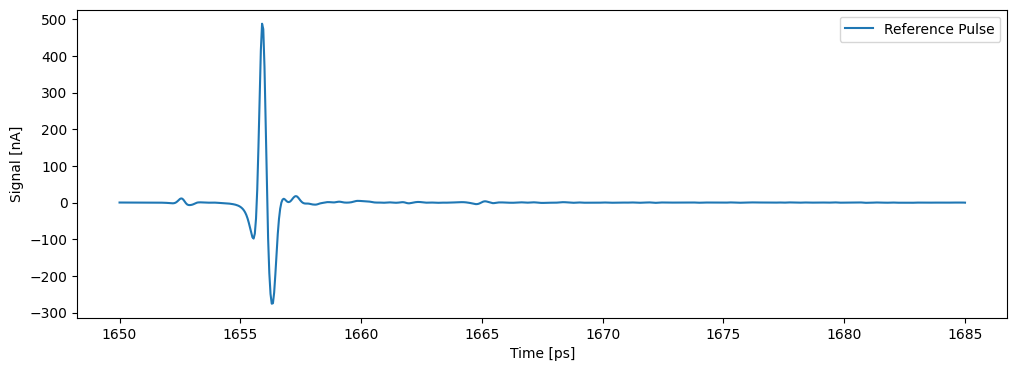

In [2]:
ref_path = 'Si_data/example_ref_pulse.csv'
ref_df = pd.read_csv(ref_path)
t_axis = ref_df['Time_abs/ps'].to_numpy()
reference_pulse = ref_df[' Signal/nA'].to_numpy()

## Remove Dc bias
halfway = len(reference_pulse) // 2
# Calculate the mean of the second half (assumed baseline)
bias = np.mean(reference_pulse[halfway:])
# Subtract the bias from the entire signal
reference_pulse = reference_pulse - bias

L = len(reference_pulse)
print(f'Length of pulse array: {L}')

print(f'Bias: {bias}')
plt.figure(figsize=(12,4))
plt.plot(t_axis, reference_pulse, label='Reference Pulse')
plt.xlabel('Time [ps]')
plt.ylabel('Signal [nA]')
plt.legend()
plt.show()

In [3]:
## Check time steps are consistent in t_axis

# Compute time differences between consecutive samples
dt = np.diff(t_axis)

# Check for uniform time step (within a small tolerance)
tolerance = 0.5e-12  # adjust as needed based on your signal's precision
is_uniform = np.all(np.abs(dt - dt[0]) < tolerance)

print("Time steps are uniform:", is_uniform)
if is_uniform:
    deltat = dt[0]
    print(f'delta_t: {deltat} ps')
if not is_uniform:
    print("Min dt:", np.min(dt))
    print("Max dt:", np.max(dt))
    print("Mean dt:", np.mean(dt))

Time steps are uniform: True
delta_t: 0.049999999999954525 ps


## Test Single layer simulated sample with experimental reference pulse

[((3.46-0.001j), 0.001)]


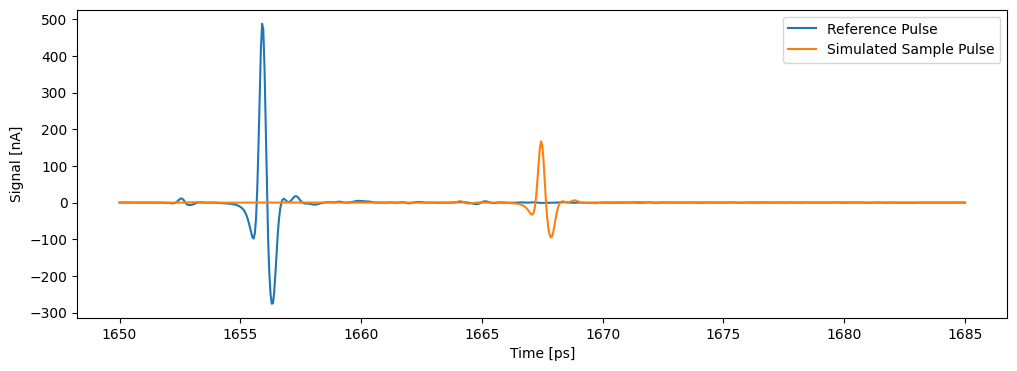

In [4]:
# Convert refence pulse to tensor
reference_pulse = torch.tensor(reference_pulse, dtype=torch.float32)

# Convert delta_t to seconds from pico seconds
deltat = deltat * 1e-12

# Material params
n1, k1, d1 = 3.46, -0.001, 1e-3

# Experimental material parameters (ground truth)
material_params_exp = ([(n1+1j*k1, d1)])

# Simulate the experimental data
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0)
experimental_pulse = experimental_pulse[:L]

print(material_params_exp)
plt.figure(figsize=(12,4))
plt.plot(t_axis, reference_pulse, label='Reference Pulse')
plt.plot(t_axis, experimental_pulse.detach().cpu().numpy(), label='Simulated Sample Pulse')
plt.xlabel('Time [ps]')
plt.ylabel('Signal [nA]')
plt.legend()
plt.show()

## Perform extraction on this data

Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (3.3, 3.5)
Layer 1 - k ∈ (-0.0115, 0.0085)
[((3.460037791948684-0.0009184967733286333j), 0.001)]


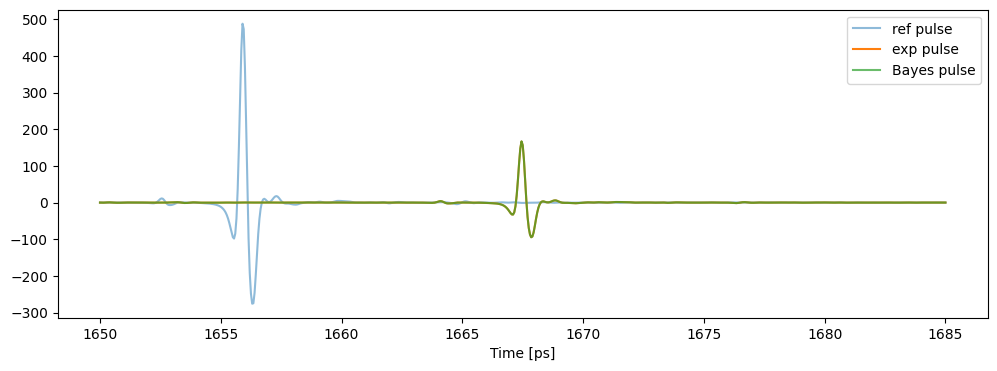

In [5]:
# set initial guesses for Bayes optimization
layers_init = [(3.4-0.0015j, 1e-3)]
# Set optimization mask
optimization_mask = [(True, True, False)]
Bayes_extractor = BayesianLayeredExtractor(reference_pulse,experimental_pulse, 
                                            deltat, layers_init, optimization_mask)

bayes_params = Bayes_extractor.bayesian_optimization()
bayes_pulse = simulate_parallel(reference_pulse, bayes_params, deltat, 0)[1].detach().cpu().numpy()[:L]

print(bayes_params)
plt.figure(figsize=(12,4))
plt.plot(t_axis, reference_pulse, label='ref pulse', alpha=0.5)
plt.plot(t_axis, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis, bayes_pulse, label='Bayes pulse', alpha=0.7)
plt.xlabel('Time [ps]')
plt.legend()
plt.show()

Fine-tuning 2 parameters for 50 iterations.
Iteration 4, Loss: 1.333571e-02, Layer 0: n=3.4600, k=-0.00096, D=1000.00 µm
Iteration 9, Loss: 1.022488e-02, Layer 0: n=3.4600, k=-0.00101, D=1000.00 µm
Iteration 14, Loss: 7.627514e-03, Layer 0: n=3.4600, k=-0.00101, D=1000.00 µm
Iteration 19, Loss: 4.615285e-03, Layer 0: n=3.4600, k=-0.00101, D=1000.00 µm
Iteration 24, Loss: 2.433777e-03, Layer 0: n=3.4600, k=-0.00101, D=1000.00 µm
Iteration 29, Loss: 7.461746e-03, Layer 0: n=3.4600, k=-0.00099, D=1000.00 µm
Iteration 34, Loss: 5.416762e-03, Layer 0: n=3.4600, k=-0.00098, D=1000.00 µm
Iteration 39, Loss: 3.927765e-03, Layer 0: n=3.4600, k=-0.00099, D=1000.00 µm
Iteration 44, Loss: 4.781792e-03, Layer 0: n=3.4600, k=-0.00100, D=1000.00 µm
Iteration 49, Loss: 1.381359e-03, Layer 0: n=3.4600, k=-0.00102, D=1000.00 µm
[((3.460005760192871-0.0009828931652009487j), 0.0009999999310821295)]


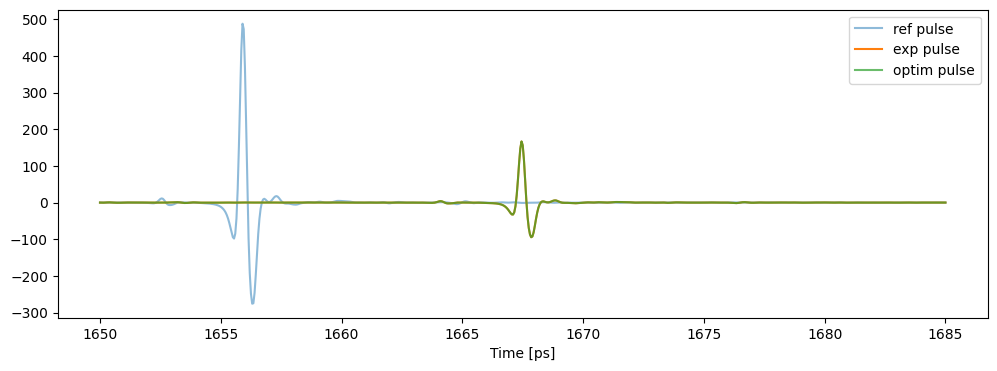

In [6]:
grad_optimizer = LayeredExtractor(reference_pulse, experimental_pulse, deltat, bayes_params, optimization_mask, lr=0.0001)
optim_params = grad_optimizer.optimize(num_iterations=50, updates=5)


optim_pulse = simulate_parallel(reference_pulse, optim_params, deltat, 0)[1].detach().cpu().numpy()[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(t_axis, reference_pulse, label='ref pulse', alpha=0.5)
plt.plot(t_axis, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis, optim_pulse, label='optim pulse', alpha=0.7)
plt.xlabel('Time [ps]')
plt.legend()
plt.show()